In [1]:
# Just ignore this shit
import sys
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, roc_curve, auc
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import warnings
import math
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
from sklearn import preprocessing

%matplotlib inline

In [2]:
# starts here
hr_data = pd.read_csv("HR_data.csv")

# Just printing the data, to visualize better
print ("X Data size:", len(hr_data))

X Data size: 10098


In [3]:
#Since the null values of "Text" and "Payscale group" are actually used in the model, we should just drop them
# It's only 60 + 10 rows out of 10,000 so shouldn't change much (same as ass 2)
hr_data.dropna(inplace=True)
len(hr_data)

10028

In [4]:
# Label encode the column! :p (Basically it will transform the column, into unique integers instead of whatever it was)
label_encoder = preprocessing.LabelEncoder()
hr_data['DIV'] = label_encoder.fit_transform(hr_data['DIV'])
hr_data['PS text'] = label_encoder.fit_transform(hr_data['PS text'])
hr_data['ESgrp'] = label_encoder.fit_transform(hr_data['ESgrp'])
hr_data['Name of ES'] = label_encoder.fit_transform(hr_data['Name of ES'])
hr_data['Name'] = label_encoder.fit_transform(hr_data['Name'])
hr_data['Location'] = label_encoder.fit_transform(hr_data['Location'])
hr_data['Pay scale text'] = label_encoder.fit_transform(hr_data['Pay scale text'])
hr_data['Gender key'] = label_encoder.fit_transform(hr_data['Gender key'])
hr_data['Current Hire Date'] = label_encoder.fit_transform(hr_data['Current Hire Date'])
hr_data['Original Hire Date'] = label_encoder.fit_transform(hr_data['Original Hire Date'])
hr_data['Text'] = label_encoder.fit_transform(hr_data['Text'])

# For pay scale (Level)
# Just going to take the code from your ass 2

hr_data['Numeric Pay Level'] = np.where(
    (pd.to_numeric(hr_data['Pay scale group (Level)'], errors='coerce').between(1, 26)), hr_data['Pay scale group (Level)'], 0)
hr_data['Non Numeric Pay Level'] = np.where(hr_data['Numeric Pay Level'] == 0, hr_data['Pay scale group (Level)'], "N/A")
hr_data['Non Numeric Pay Level'] = label_encoder.fit_transform(hr_data['Non Numeric Pay Level'])

hr_data.head()

,EmployeeID,DivNo,DIV,PSubarea,PS text,ESgrp,Name of ES,S,Name,Location,...,Text,RNG,RNG.1,Voluntary Turnover,All Turnover,Report date,Firm Tenure days,Job Tenure days,Numeric Pay Level,Non Numeric Pay Level
0,6256,1548,0,600,28,8,9,3,0,8,...,2,1,1,0,0,2014-01-15,15129.0,15129,14,38
1,8849,1548,0,600,28,8,9,3,0,8,...,8,1,0,0,0,2014-01-15,14659.0,14659,15,38
2,10342,1548,0,600,28,7,8,3,0,8,...,2,1,0,0,0,2014-01-15,14593.0,14593,8,38
3,4731,1548,0,600,28,7,8,3,0,8,...,2,0,1,1,1,2014-01-15,13624.0,13624,11,38
4,10317,1548,0,610,31,8,9,3,0,8,...,8,0,1,0,0,2014-01-15,13456.0,10166,14,38


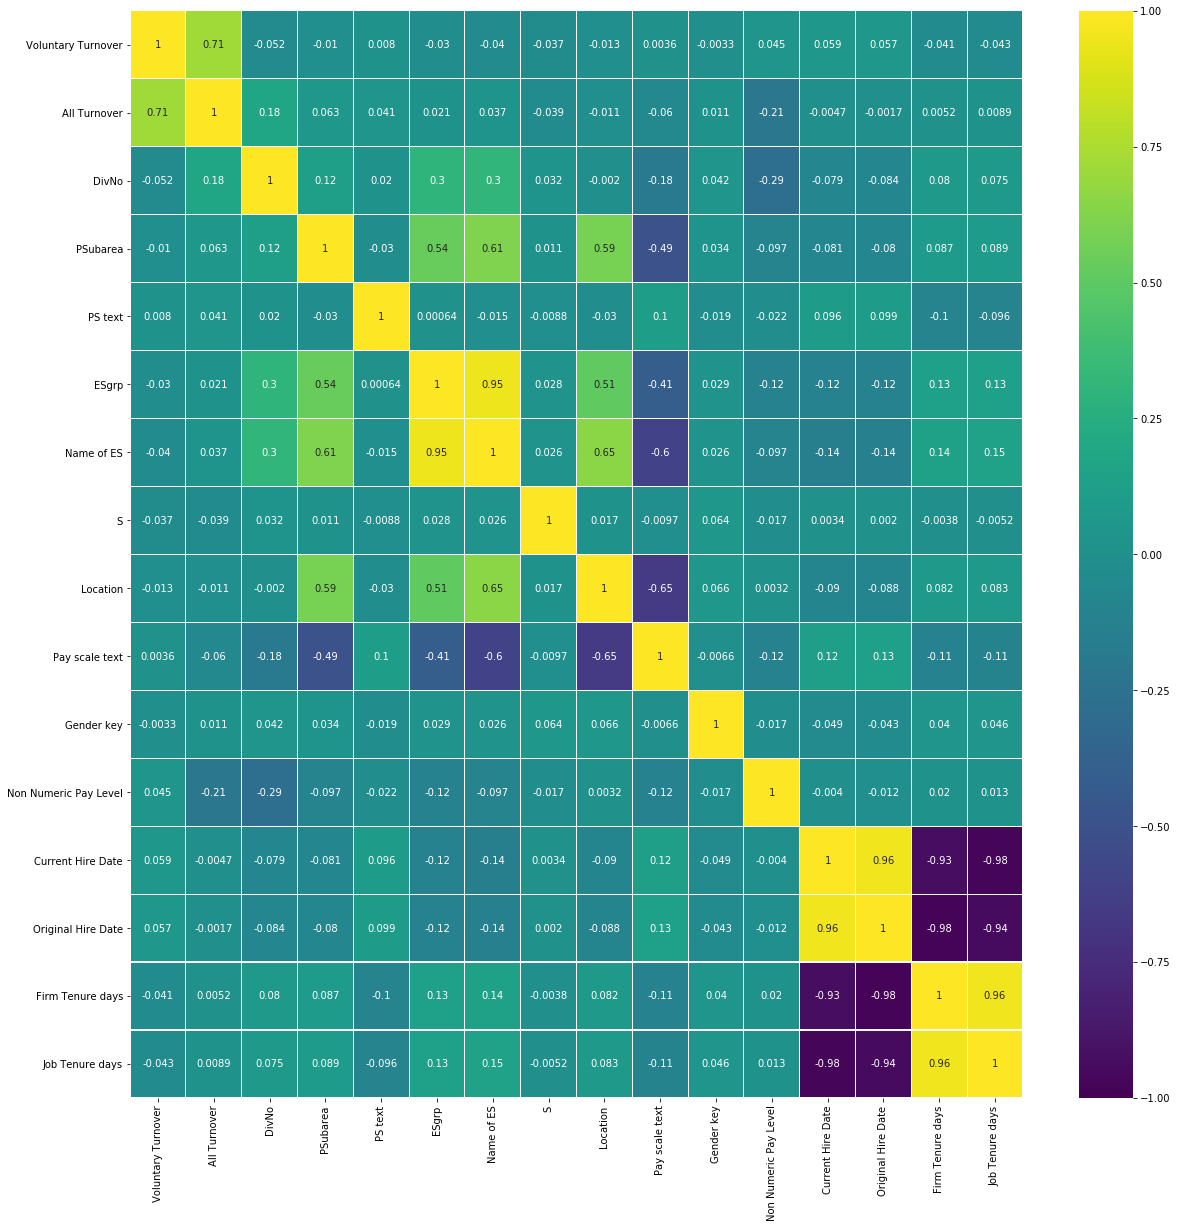

In [5]:
# We can print correlations of each field with other fields and try to find if there are any 2 very correlated fields ..
# (This is just for curiosity) ... but might be helpful!
plt.figure(figsize=(20,20))
cols = ['Voluntary Turnover','All Turnover','DivNo', 'PSubarea', 'PS text', 'ESgrp', 'Name of ES', 'S', 'Location', 'Pay scale text', 'Gender key', 'Numeric Pay Level', 'Non Numeric Pay Level', 'Current Hire Date', 'Original Hire Date', 'Firm Tenure days', 'Job Tenure days']
correlation = hr_data[cols].corr()
sns.heatmap(correlation, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

In [6]:
# Well the graph is pretty shit ....... what if we normalize the data .. maybe that would help
min_max_scaler = preprocessing.MinMaxScaler()
hr_data_scaled = min_max_scaler.fit_transform(hr_data[cols])

hr_data_scaled = pd.DataFrame(hr_data_scaled, columns=[cols])
hr_data_scaled.head()

,Voluntary Turnover,All Turnover,DivNo,PSubarea,PS text,ESgrp,Name of ES,S,Location,Pay scale text,Gender key,Numeric Pay Level,Non Numeric Pay Level,Current Hire Date,Original Hire Date,Firm Tenure days,Job Tenure days
0,0.0,0.0,0.147287,0.440,0.756757,0.8,0.9,1.0,0.8,0.000000,0.5,0.538462,0.926829,0.004029,0.004335,0.799137,0.799137
1,0.0,0.0,0.147287,0.440,0.756757,0.8,0.9,1.0,0.8,0.000000,0.5,0.576923,0.926829,0.006714,0.006935,0.774705,0.774705
2,0.0,0.0,0.147287,0.440,0.756757,0.7,0.8,1.0,0.8,0.333333,0.0,0.307692,0.926829,0.008057,0.008236,0.771274,0.771274
3,1.0,1.0,0.147287,0.440,0.756757,0.7,0.8,1.0,0.8,0.333333,0.5,0.423077,0.926829,0.021038,0.021240,0.720902,0.720902
4,0.0,0.0,0.147287,0.448,0.837838,0.8,0.9,1.0,0.8,0.000000,0.0,0.538462,0.926829,0.112802,0.023407,0.712169,0.541145


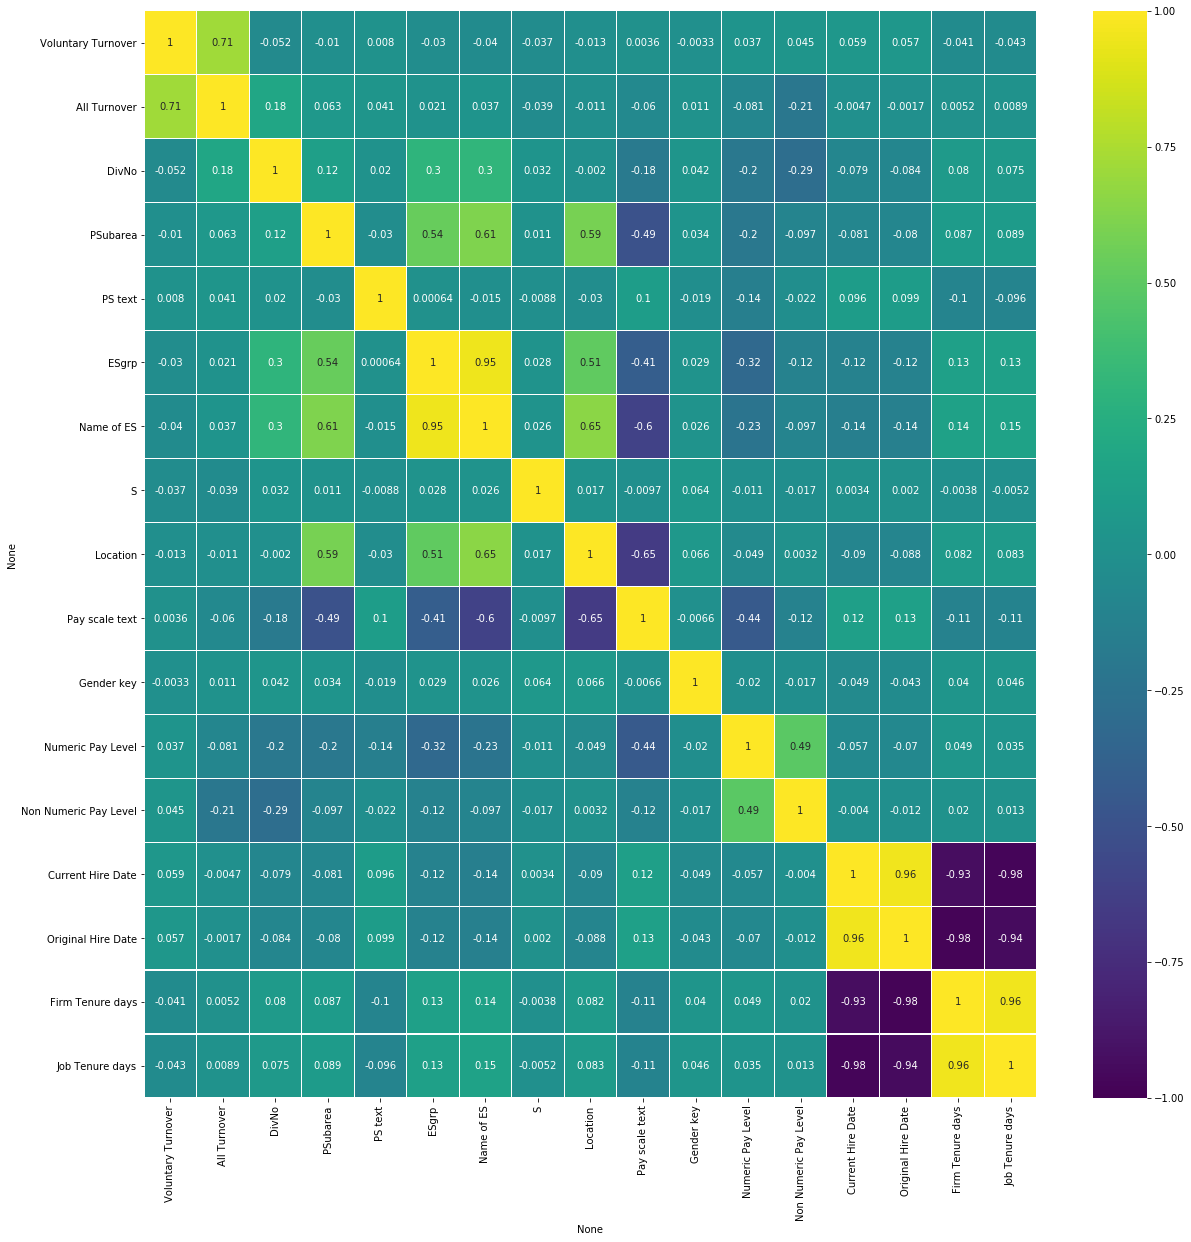

In [7]:
# Okay let's see the correlations again
plt.figure(figsize=(20,20))
sns.heatmap(hr_data_scaled.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

In [8]:
# Alright well it's pretty much the same shit LOL
# Let's start splitting data around! We'll start with predicting All turnover
# Im gonna try with just the three predicator variables (DivNO, PSuberea, and PS text)
# So something like Y = b0 + DivNO*b1 + DivNo^2*b2 + PSubarea*b3 + PSubarea^2*b4 + PS text*b5 + PS text^2*b6
X_data = hr_data[['DivNo', 'PSubarea', 'PS text']]

X_data.insert(1, 'DivNo sq', np.square(hr_data['DivNo']))
X_data.insert(3, 'PSubarea sq', np.square(hr_data['PSubarea']))
X_data.insert(5, 'PS text sq', np.square(hr_data['PS text']))

Y_all_turnover_data = hr_data['All Turnover']

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_all_turnover_data, test_size = 0.5)
print ("X train data length: ", len(X_train))
print ("Y train data length: ", len(Y_train))

print ("X test data length: ", len(X_test))
print ("Y test data length: ", len(Y_test))

X_train.head()

X train data length:  5014
Y train data length:  5014
X test data length:  5014
Y test data length:  5014


,DivNo,DivNo sq,PSubarea,PSubarea sq,PS text,PS text sq
3881,1544,2383936,200,40000,22,484
5451,1544,2383936,200,40000,22,484
3134,1544,2383936,500,250000,18,324
2220,1544,2383936,500,250000,18,324
2249,1544,2383936,750,562500,34,1156


In [9]:
# Let's seeeeeeee
# Finally we fit the model!!

# add the columns of 1s
X_train = sm.add_constant(X_train)
# X_train
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           All Turnover   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     80.52
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           1.72e-96
Time:                        00:23:51   Log-Likelihood:                -1531.1
No. Observations:                5014   AIC:                             3076.
Df Residuals:                    5007   BIC:                             3122.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         172.1131     12.116     14.206      0.000     148.361     195.865
DivNo          -0.2192      0.015    -14.351      0.000      -0.249      -0.189
DivNo sq     6.973e-05   4.81e-06     14.497      0.000    6.03e-05    7.92e-05
PSubarea        0.0006   7.99e-05      7.265      0.000       0.000       0.001
PSubarea sq -4.644e-07   7.63e-08     -6.084      0.000   -6.14e-07   -3.15e-07
PS text         0.0087      0.003      2.612      0.009       0.002       0.015
PS text sq     -0.0002   8.42e-05     -2.405      0.016      -0.000   -3.74e-05
==============================================================================
Omnibus:                     1768.077   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4740.932
Skew:                           1.948   Prob(JB):                         0.00
Kurtosis:                       5.742   Cond. No.                     6.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Make the new column and fill it up with the results
X_test['Predicted All Turnover'] = results.predict()
X_test.loc[:, 'All Turnover'] = Y_test

X_test.head(50)
# X_train['Predicted All Turnover'].max()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,DivNo,DivNo sq,PSubarea,PSubarea sq,PS text,PS text sq,Predicted All Turnover,All Turnover
4638,1544,2383936,320,102400,24,576,0.082322,1
4608,1544,2383936,200,40000,22,484,0.082322,1
5466,1544,2383936,200,40000,22,484,0.156662,1
1814,1544,2383936,760,577600,5,25,0.156662,0
2224,1544,2383936,1000,1000000,16,256,0.126806,0
3985,1544,2383936,200,40000,22,484,0.082322,0
251,1548,2396304,640,409600,8,64,0.599724,0
5931,1544,2383936,1100,1210000,14,196,0.103327,0
605,1548,2396304,640,409600,8,64,0.116985,0
1867,1544,2383936,1000,1000000,16,256,0.082322,0


In [11]:
# So next = Vol Turnover ...
# Y = b0 + Non Numeric Pay Level*b1 + Non Numeric Pay Level^2*b2 + Current Hire Date*b3 + Current Hire Date^2*b4 + Original Hire Date*b5 +Original Hire Date^2*b6
X2_data = hr_data[['Non Numeric Pay Level', 'Current Hire Date', 'Original Hire Date']]

X2_data.insert(1, 'Non Numeric Pay Level sq', np.square(hr_data['Non Numeric Pay Level']))
X2_data.insert(3, 'Current Hire Date sq', np.square(hr_data['Current Hire Date']))
X2_data.insert(5, 'Original Hire Date sq', np.square(hr_data['Original Hire Date']))

Y_vol_turnover_data = hr_data['Voluntary Turnover']

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_data, Y_vol_turnover_data, test_size = 0.5)
print ("X train data length: ", len(X2_train))
print ("Y train data length: ", len(Y2_train))

print ("X test data length: ", len(X2_test))
print ("Y test data length: ", len(Y2_test))

X2_train.head()

X train data length:  5014
Y train data length:  5014
X test data length:  5014
Y test data length:  5014


,Non Numeric Pay Level,Non Numeric Pay Level sq,Current Hire Date,Current Hire Date sq,Original Hire Date,Original Hire Date sq
4935,38,1444,1935,3744225,2021,4084441
4111,38,1444,1820,3312400,1776,3154176
2668,38,1444,1233,1520289,1318,1737124
4998,38,1444,1947,3790809,2033,4133089
9050,38,1444,1338,1790244,1421,2019241


In [12]:
#Lets fit the model againnnn

# Add cols of 1s for the model
X2_train = sm.add_constant(X2_train)

results2 = sm.OLS(Y2_train, X2_train).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Voluntary Turnover   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     9.333
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           3.34e-10
Time:                        00:23:51   Log-Likelihood:                -469.39
No. Observations:                5014   AIC:                             952.8
Df Residuals:                    5007   BIC:                             998.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0217      0.098      0.221      0.825      -0.170       0.213
Non Numeric Pay Level       -0.0032      0.008     -0.423      0.672      -0.018       0.012
Non Numeric Pay Level sq     0.0001      0.000      0.904      0.366      -0.000       0.000
Current Hire Date          8.36e-05    9.2e-05      0.909      0.364   -9.68e-05       0.000
Current Hire Date sq     -1.672e-08   3.45e-08     -0.485      0.628   -8.43e-08    5.09e-08
Original Hire Date          -0.0002   8.73e-05     -1.800      0.072      -0.000     1.4e-05
Original Hire Date sq     5.746e-08   3.17e-08      1.810      0.070   -4.76e-09     1.2e-07
==============================================================================
Omnibus:                     3108.562   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20847.402
Skew:                           3.109   Prob(JB):                         0.00
Kurtosis:                      10.818   Cond. No.                     1.16e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

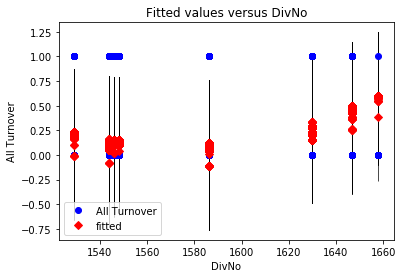

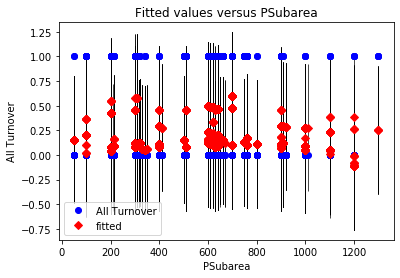

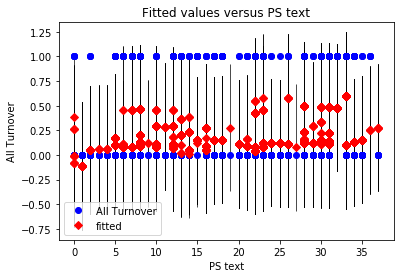

In [13]:
# We can print some graphs to visualize a bit ....
fig, ax_divNo = plt.subplots()
fig, ax_Sa = plt.subplots()
fig, ax_Pt = plt.subplots()

fig = sm.graphics.plot_fit(results, 1, ax=ax_divNo) # DivNo
fig = sm.graphics.plot_fit(results, 3, ax=ax_Sa) # SubArea
fig = sm.graphics.plot_fit(results, 5, ax=ax_Pt) # PS Text

In [14]:
# Make the new column and fill it up with the results
X2_test['Predicted Voluntary Turnover'] = results2.predict()
X2_test.loc[:, 'Voluntary Turnover'] = Y2_test

X2_test.head(50)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,Non Numeric Pay Level,Non Numeric Pay Level sq,Current Hire Date,Current Hire Date sq,Original Hire Date,Original Hire Date sq,Predicted Voluntary Turnover,Voluntary Turnover
7159,38,1444,1664,2768896,1754,3076516,0.097553,0
9650,4,16,963,927369,1047,1096209,0.080189,0
9588,38,1444,574,329476,640,409600,0.051603,0
4434,38,1444,1852,3429904,1939,3759721,0.098687,0
312,38,1444,1045,1092025,1125,1265625,0.055898,0
3424,38,1444,1449,2099601,1530,2340900,0.049570,0
7432,38,1444,1787,3193369,1875,3515625,0.121903,0
1977,38,1444,910,828100,993,986049,0.051282,0
379,38,1444,1160,1345600,1243,1545049,0.072191,0
7623,38,1444,1787,3193369,1875,3515625,0.059427,0


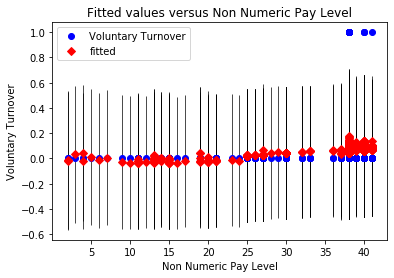

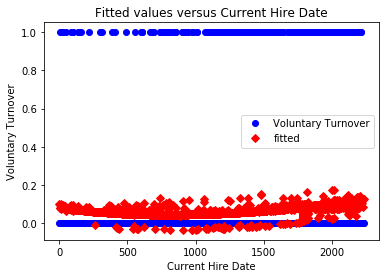

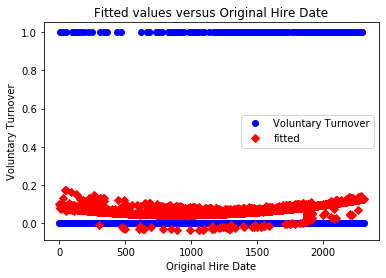

In [15]:
# We can print some graphs to visualize a bit ....
fig, ax_NonNumeric = plt.subplots()
fig, ax_Chd = plt.subplots()
fig, ax_Ohd = plt.subplots()

fig = sm.graphics.plot_fit(results2, 1, ax=ax_NonNumeric) # NonNumeric Pay lev
fig = sm.graphics.plot_fit(results2, 3, ax=ax_Chd, vlines=False) # Curr hire date
fig = sm.graphics.plot_fit(results2, 5, ax=ax_Ohd, vlines=False) # Org hire date

In [16]:
# Correlations ... horrible LOL
all_turn_corr = X_test['Predicted All Turnover'].corr(X_test['All Turnover'])
vol_turn_corr = X2_test['Predicted Voluntary Turnover'].corr(X2_test['Voluntary Turnover'])
print ("All turnover corr:", all_turn_corr)
print("Vol turnover corr:", vol_turn_corr)

All turnover corr: 0.014493477882074888
Vol turnover corr: -0.008963590978639925


In [17]:
# Comparing with the R^2s, ohh boy
print ("All turnover corr^2:", np.square(all_turn_corr), " with r squared:", results.rsquared)
print ("Voluntary turnover corr^2:", np.square(vol_turn_corr), " with r squared:", results2.rsquared)

All turnover corr^2: 0.00021006090111819398  with r squared: 0.08800135624657146
Voluntary turnover corr^2: 8.034596323235505e-05  with r squared: 0.011059906928618912


In [18]:
# For the thresholds,we'll just take the mean of the values ...

all_turn_threshold = np.mean([X_test['Predicted All Turnover'].max(), X_test['Predicted All Turnover'].min()]) 
vol_turn_threshold = np.mean([X2_test['Predicted Voluntary Turnover'].max(), X2_test['Predicted Voluntary Turnover'].min()])

print ("All turnover threshold:", all_turn_threshold)
print ("Voluntary turnover threshold:", vol_turn_threshold)

All turnover threshold: 0.24400156504640552
Voluntary turnover threshold: 0.06928625037945566


In [19]:
# Now i'm gonna cycle through the rows and for each value, if its higher then threshold, set it to 1, else set it to 0
X_test['Predicted All Turnover'] = np.where(X_test['Predicted All Turnover'] > all_turn_threshold, 1, 0)
X_test.head(50)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DivNo,DivNo sq,PSubarea,PSubarea sq,PS text,PS text sq,Predicted All Turnover,All Turnover
4638,1544,2383936,320,102400,24,576,0,1
4608,1544,2383936,200,40000,22,484,0,1
5466,1544,2383936,200,40000,22,484,0,1
1814,1544,2383936,760,577600,5,25,0,0
2224,1544,2383936,1000,1000000,16,256,0,0
3985,1544,2383936,200,40000,22,484,0,0
251,1548,2396304,640,409600,8,64,1,0
5931,1544,2383936,1100,1210000,14,196,0,0
605,1548,2396304,640,409600,8,64,0,0
1867,1544,2383936,1000,1000000,16,256,0,0


In [20]:
# Now i'm gonna cycle through the rows and for each value, if its higher then threshold, set it to 1, else set it to 0
X2_test['Predicted Voluntary Turnover (First Sensitivity)'] = np.where(X2_test['Predicted Voluntary Turnover'] > vol_turn_threshold, 1, 0)
X2_test.head(5)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Non Numeric Pay Level,Non Numeric Pay Level sq,Current Hire Date,Current Hire Date sq,Original Hire Date,Original Hire Date sq,Predicted Voluntary Turnover,Voluntary Turnover,Predicted Voluntary Turnover (First Sensitivity)
7159,38,1444,1664,2768896,1754,3076516,0.097553,0,1
9650,4,16,963,927369,1047,1096209,0.080189,0,1
9588,38,1444,574,329476,640,409600,0.051603,0,0
4434,38,1444,1852,3429904,1939,3759721,0.098687,0,1
312,38,1444,1045,1092025,1125,1265625,0.055898,0,0


In [21]:
# True positives .. True negatives, etc (All turnover first!)
true_positive_all_turnover = X_test['All Turnover'].loc[
    (X_test['Predicted All Turnover'] == 1) & (X_test['All Turnover'] == 1)].count()

false_positive_all_turnover = X_test['All Turnover'].loc[
    (X_test['Predicted All Turnover'] == 1) & (X_test['All Turnover'] == 0)].count()

true_negative_all_turnover = X_test['All Turnover'].loc[
    (X_test['Predicted All Turnover'] == 0) & (X_test['All Turnover'] == 0)].count()

false_negative_all_turnover = X_test['All Turnover'].loc[
    (X_test['Predicted All Turnover'] == 0) & (X_test['All Turnover'] == 1)].count()

total_all_turnover = np.sum([true_positive_all_turnover, false_positive_all_turnover, true_negative_all_turnover, false_negative_all_turnover])
print ("All turnovers!!! =======")

print("True positive:", true_positive_all_turnover)
print("False positive:", false_positive_all_turnover)
print("True negative:", true_negative_all_turnover)
print("False negative:", false_negative_all_turnover)
print("Total:",total_all_turnover)

All turnovers!!! =======
True positive: 60
False positive: 328
True negative: 3996
False negative: 630
Total: 5014


In [22]:
# True positives .. True negatives, etc (Voluntary turnover now!) (First Sensitivitiy)
true_positive_vol_turnover = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (First Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 1)].count()

false_positive_vol_turnover = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (First Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 0)].count()

true_negative_vol_turnover = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (First Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 0)].count()

false_negative_vol_turnover = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (First Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 1)].count()

total_vol_turnover = np.sum([true_positive_vol_turnover, false_positive_vol_turnover, true_negative_vol_turnover, false_negative_vol_turnover])

print ("Voluntary turnovers!!! =======")

print("True positive:", true_positive_vol_turnover)
print("False positive:", false_positive_vol_turnover)
print("True negative:", true_negative_vol_turnover)
print("False negative:", false_negative_vol_turnover)
print("Total:",total_vol_turnover)

Voluntary turnovers!!! =======
True positive: 203
False positive: 2689
True negative: 1960
False negative: 162
Total: 5014


In [23]:
# Sensitivity and Specificity scores ... (first Sensitivity)
all_turnover_actual_positive = X_test['All Turnover'].loc[X_test['All Turnover'] == 1].count()
all_turnover_actual_negative = X_test['All Turnover'].loc[X_test['All Turnover'] == 0].count()

vol_turnover_actual_positive = X2_test['Voluntary Turnover'].loc[X2_test['Voluntary Turnover'] == 1].count()
vol_turnover_actual_negative = X2_test['Voluntary Turnover'].loc[X2_test['Voluntary Turnover'] == 0].count()

all_turnover_sensitivity = np.divide(true_positive_all_turnover, all_turnover_actual_positive)
all_turnover_specificity = np.divide(true_negative_all_turnover, all_turnover_actual_negative)

vol_turnover_sensitivity = np.divide(true_positive_vol_turnover, vol_turnover_actual_positive)
vol_turnover_specificity = np.divide(true_negative_vol_turnover, vol_turnover_actual_negative)

print("All Turnover =========")
print ("Sensitivity:", all_turnover_sensitivity)
print ("Specificity:", all_turnover_specificity)


print("\nVoluntary Turnover =========")
print ("Sensitivity:", vol_turnover_sensitivity)
print ("Specificity:", vol_turnover_specificity)

All Turnover =========
Sensitivity: 0.08695652173913043
Specificity: 0.9241443108233117

Voluntary Turnover =========
Sensitivity: 0.5561643835616439
Specificity: 0.4215960421596042


In [24]:
# Changing sensitivity for Voluntary Turnover to a little more strict! Just adding 15%
vol_turn_threshold_two = np.mean([X2_test['Predicted Voluntary Turnover'].max(), X2_test['Predicted Voluntary Turnover'].min()])
vol_turn_threshold_two = vol_turn_threshold_two + (vol_turn_threshold_two/50)

print ("New Voluntary turnover threshold:", vol_turn_threshold_two)

New Voluntary turnover threshold: 0.07067197538704477


In [25]:
# Now i'm gonna cycle through the rows and for each value, if its higher then threshold, set it to 1, else set it to 0
X2_test['Predicted Voluntary Turnover (Second Sensitivity)'] = np.where(X2_test['Predicted Voluntary Turnover'] > vol_turn_threshold_two, 1, 0)
X2_test.head(5)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Non Numeric Pay Level,Non Numeric Pay Level sq,Current Hire Date,Current Hire Date sq,Original Hire Date,Original Hire Date sq,Predicted Voluntary Turnover,Voluntary Turnover,Predicted Voluntary Turnover (First Sensitivity),Predicted Voluntary Turnover (Second Sensitivity)
7159,38,1444,1664,2768896,1754,3076516,0.097553,0,1,1
9650,4,16,963,927369,1047,1096209,0.080189,0,1,1
9588,38,1444,574,329476,640,409600,0.051603,0,0,0
4434,38,1444,1852,3429904,1939,3759721,0.098687,0,1,1
312,38,1444,1045,1092025,1125,1265625,0.055898,0,0,0


In [26]:
# True positives .. True negatives, etc (Voluntary turnover now!) (Second Sensitivitiy)
true_positive_vol_turnover_two = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Second Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 1)].count()

false_positive_vol_turnover_two = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Second Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 0)].count()

true_negative_vol_turnover_two = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Second Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 0)].count()

false_negative_vol_turnover_two = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Second Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 1)].count()

total_vol_turnover_two = np.sum([true_positive_vol_turnover_two, false_positive_vol_turnover_two, true_negative_vol_turnover_two, false_negative_vol_turnover_two])

print ("Voluntary turnovers!!! Round 2 =======")

print("True positive:", true_positive_vol_turnover_two)
print("False positive:", false_positive_vol_turnover_two)
print("True negative:", true_negative_vol_turnover_two)
print("False negative:", false_negative_vol_turnover_two)
print("Total:",total_vol_turnover_two)

Voluntary turnovers!!! Round 2 =======
True positive: 200
False positive: 2608
True negative: 2041
False negative: 165
Total: 5014


In [27]:
# Sensitivity and Specificity scores ... (Second Sensitivity) Only for Voluntary turnover
vol_turnover_sensitivity_two = np.divide(true_positive_vol_turnover_two, vol_turnover_actual_positive)
vol_turnover_specificity_two = np.divide(true_negative_vol_turnover_two, vol_turnover_actual_negative)

print("\nVoluntary Turnover =========")
print ("Sensitivity:", vol_turnover_sensitivity_two)
print ("Specificity:", vol_turnover_specificity_two)


Voluntary Turnover =========
Sensitivity: 0.547945205479452
Specificity: 0.4390191439019144


In [28]:
# Changing sensitivity for Voluntary Turnover to a little more strict! Just adding 60% this time
vol_turn_threshold_three = np.mean([X2_test['Predicted Voluntary Turnover'].max(), X2_test['Predicted Voluntary Turnover'].min()])
vol_turn_threshold_three = vol_turn_threshold_three - (vol_turn_threshold_three/50)

print ("NEW New Voluntary turnover threshold:", vol_turn_threshold_three)

NEW New Voluntary turnover threshold: 0.06790052537186654


In [29]:
# Now i'm gonna cycle through the rows and for each value, if its higher then threshold, set it to 1, else set it to 0
X2_test['Predicted Voluntary Turnover (Third Sensitivity)'] = np.where(X2_test['Predicted Voluntary Turnover'] > vol_turn_threshold_three, 1, 0)
X2_test.head(5)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Non Numeric Pay Level,Non Numeric Pay Level sq,Current Hire Date,Current Hire Date sq,Original Hire Date,Original Hire Date sq,Predicted Voluntary Turnover,Voluntary Turnover,Predicted Voluntary Turnover (First Sensitivity),Predicted Voluntary Turnover (Second Sensitivity),Predicted Voluntary Turnover (Third Sensitivity)
7159,38,1444,1664,2768896,1754,3076516,0.097553,0,1,1,1
9650,4,16,963,927369,1047,1096209,0.080189,0,1,1,1
9588,38,1444,574,329476,640,409600,0.051603,0,0,0,0
4434,38,1444,1852,3429904,1939,3759721,0.098687,0,1,1,1
312,38,1444,1045,1092025,1125,1265625,0.055898,0,0,0,0


In [30]:
# True positives .. True negatives, etc (Voluntary turnover now!) (Thirdd Sensitivitiy)
true_positive_vol_turnover_three = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Third Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 1)].count()

false_positive_vol_turnover_three = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Third Sensitivity)'] == 1) & (X2_test['Voluntary Turnover'] == 0)].count()

true_negative_vol_turnover_three = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Third Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 0)].count()

false_negative_vol_turnover_three = X2_test['Voluntary Turnover'].loc[
    (X2_test['Predicted Voluntary Turnover (Third Sensitivity)'] == 0) & (X2_test['Voluntary Turnover'] == 1)].count()

total_vol_turnover_three = np.sum([true_positive_vol_turnover_three, false_positive_vol_turnover_three, true_negative_vol_turnover_three, false_negative_vol_turnover_three])

print ("Voluntary turnovers!!! Round 3 =======")

print("True positive:", true_positive_vol_turnover_three)
print("False positive:", false_positive_vol_turnover_three)
print("True negative:", true_negative_vol_turnover_three)
print("False negative:", false_negative_vol_turnover_three)
print("Total:",total_vol_turnover_three)

Voluntary turnovers!!! Round 3 =======
True positive: 208
False positive: 2756
True negative: 1893
False negative: 157
Total: 5014


In [31]:
# Sensitivity and Specificity scores ... (Second Sensitivity) Only for Voluntary turnover
vol_turnover_sensitivity_three = np.divide(true_positive_vol_turnover_three, vol_turnover_actual_positive)
vol_turnover_specificity_three = np.divide(true_negative_vol_turnover_three, vol_turnover_actual_negative)

print("\nVoluntary Turnover Round 3 =========")
print ("Sensitivity:", vol_turnover_sensitivity_three)
print ("Specificity:", vol_turnover_specificity_three)


Voluntary Turnover Round 3 =========
Sensitivity: 0.5698630136986301
Specificity: 0.40718434071843407


X axis [0.42159604 0.43901914 0.40718434]
Y axis: [0.55616438 0.54794521 0.56986301]


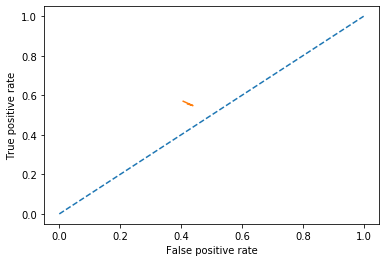

In [34]:
# red dashes, blue squares and green triangles
Y_axis = np.array([vol_turnover_sensitivity, vol_turnover_sensitivity_two, vol_turnover_sensitivity_three])
X_axis = np.array([vol_turnover_specificity, vol_turnover_specificity_two, vol_turnover_specificity_three])

print ("X axis", X_axis)
print ("Y axis:", Y_axis)

plt.plot([0, 1], [0, 1], "--")
plt.plot(X_axis, Y_axis)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()